In [ ]:
import os
import sys

os.chdir("..")
# print("Now CWD is:", os.getcwd())

%pip install nbformat
%pip install import-ipynb

import numpy as np
import matplotlib.pyplot as plt

from utils.mnist_reader import load_mnist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import learning_curve
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    classification_report
)

# change back
os.chdir("models")
print("Now CWD is:", os.getcwd())



Note: you may need to restart the kernel to use updated packages.
Now CWD is: /Users/zackeryhe/Desktop/sophomore/cs178/178-final/models


In [61]:
class KNNModel:
    def __init__(self, n_neighbors: int = 5, **kwargs):
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors, **kwargs)
        self.class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']
    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def plot_learning_curve(self, X, y, cv=5, scoring='accuracy',
                            train_sizes=np.linspace(0.1, 1.0, 5)):
        train_sizes, train_scores, val_scores = learning_curve(
            self.model, X, y,
            cv=cv,
            scoring=scoring,
            train_sizes=train_sizes,
            n_jobs=-1,
            shuffle=True,
            random_state=1234
        )
        train_mean = np.mean(train_scores, axis=1)
        val_mean   = np.mean(val_scores, axis=1)

        plt.figure()
        plt.plot(train_sizes, train_mean, 'o-', label="Train score")
        plt.plot(train_sizes, val_mean,   'o-', label="CV score")
        plt.xlabel("Training examples")
        plt.ylabel(scoring.capitalize())
        plt.title("Learning Curve")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, X, y, normalize=None, cmap=plt.cm.Blues):
        # y_pred = self.predict(X)
        # cm = confusion_matrix(y, y_pred, normalize=normalize)
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        #                               display_labels=self.model.classes_)
        # plt.figure()
        # disp.plot(cmap=cmap, values_format='.2f' if normalize else 'd',
        #           xticks_rotation=45)
        # disp.plot(cmap=cmap, values_format='.2f' if normalize else 'd',
        #           xticks_rotation=45)
        # plt.title("Confusion Matrix" + (f" (normalized)" if normalize else ""))
        # plt.show()
        # Confusion matrix
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)

        plt.figure()
        plt.imshow(cm, interpolation='nearest')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.xticks(np.arange(10), self.class_names, rotation=45)
        plt.yticks(np.arange(10), self.class_names)
        # annotate counts
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j], ha='center', va='center')
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curve(self, X, y, average='micro'):
        if not hasattr(self.model, "predict_proba"):
            raise AttributeError("Model has no `predict_proba`—cannot get scores.")
        
        y_bin = label_binarize(y, classes=self.model.classes_)
        y_score = self.model.predict_proba(X)

        precision, recall, _ = precision_recall_curve(
            y_bin.ravel(), y_score.ravel()
        )
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        plt.figure()
        disp.plot()
        plt.title(f"Precision–Recall Curve ({average}-average)")
        plt.show()

    def plot_error_rate_vs_k(self, X_train, y_train, X_test, y_test, k_range=None):
        """
        Since K-NN has no training epochs, plot error rate vs. number of neighbors (k).
        """
        if k_range is None:
            k_range = range(1, 21)
        error_rates = []
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            error = 1 - knn.score(X_test, y_test)
            error_rates.append(error)

        plt.figure()
        plt.plot(list(k_range), error_rates, 'o-')
        plt.xlabel("Number of neighbors (k)")
        plt.ylabel("Error rate")
        plt.title("Error Rate vs. k")
        plt.grid(True)
        plt.show()

    def print_classification_report(self, X, y):
        y_pred = self.predict(X)
        report = classification_report(y, y_pred, target_names=self.class_names)
        print(report)
    
    def get_classification_report(self, X, y):
        y_pred = self.predict(X)
        report_dict = classification_report(y, y_pred,
                                            target_names=self.class_names,
                                            output_dict=True)
        return report_dict
    
    def plot_classification_report(self, X, y, figsize=(8, 5), title="Classification Report"):
        """
        Predict on X, then compute the sklearn classification_report as a dict and plot
        Precision / Recall / F1 for each class as grouped bar charts.

        Parameters:
        -----------
        X : array‐like, shape (n_samples, n_features)
            Features to predict on.

        y : array‐like, shape (n_samples,)
            True labels.

        figsize : tuple (width, height), optional
            Figure size for the matplotlib plot.

        title : str, optional
            Title of the plot.

        Usage:
        ------
            model.plot_classification_report(X_test, y_test)
        """
        # 1) Get predictions & report‐dict
        y_pred = self.predict(X)
        report_dict = classification_report(y, y_pred,
                                            target_names=self.class_names,
                                            output_dict=True)

        # 2) Pull out precision / recall / f1 for each class (ignore 'accuracy', 'macro avg', etc.)
        class_labels = []
        precisions = []
        recalls = []
        f1s = []

        for cls in self.class_names:
            cls_metrics = report_dict.get(cls, None)
            if cls_metrics is None:
                continue
            class_labels.append(cls)
            precisions.append(cls_metrics["precision"])
            recalls.append(cls_metrics["recall"])
            f1s.append(cls_metrics["f1-score"])

        # 3) Plot
        n_classes = len(class_labels)
        ind = np.arange(n_classes)                  # the x locations for the groups
        width = 0.25                                # the width of each bar

        fig, ax = plt.subplots(figsize=figsize)
        rects1 = ax.bar(ind - width, precisions, width, label="Precision")
        rects2 = ax.bar(ind,        recalls,    width, label="Recall")
        rects3 = ax.bar(ind + width, f1s,       width, label="F1-Score")

        # 4) Formatting
        ax.set_ylabel("Score")
        ax.set_ylim(0.0, 1.05)   # since metrics are in [0, 1]
        ax.set_title(title)
        ax.set_xticks(ind)
        ax.set_xticklabels(class_labels, rotation=45, ha="right")
        ax.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15))

        # Annotate bars with their value
        def annotate_bars(bar_list):
            for rect in bar_list:
                height = rect.get_height()
                ax.annotate(f"{height:.2f}",
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 2),  # 2 points vertical offset
                            textcoords="offset points",
                            ha="center", va="bottom", fontsize=8)

        annotate_bars(rects1)
        annotate_bars(rects2)
        annotate_bars(rects3)

        plt.tight_layout()
        plt.show()



In [ ]:
if __name__ == "__main__":
  X_train, y_train = load_mnist('../data/fashion', kind='train')
  X_test,  y_test  = load_mnist('../data/fashion', kind='t10k')


  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test  = scaler.transform(X_test)

  knn = KNNModel(n_neighbors=3)
  knn.fit(X_train, y_train)


In [ ]:
if __name__ == "__main__":
  print("should nto run")
  print("Train accuracy:", knn.score(X_train, y_train))
  print("Test accuracy: ", knn.score(X_test,  y_test))


Train accuracy: 0.9204
Test accuracy:  0.8496


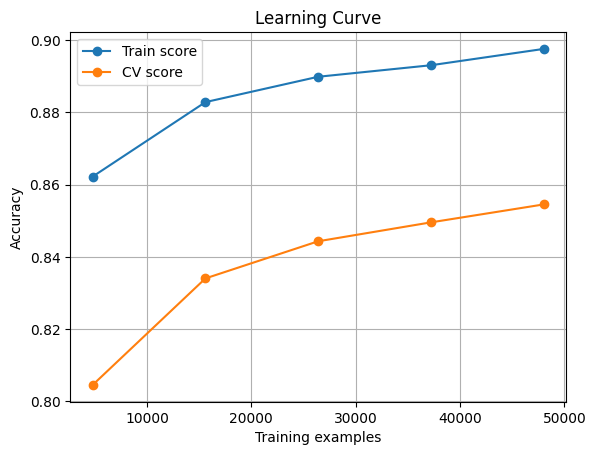

In [ ]:
if __name__ == "__main__":
  knn.plot_learning_curve(X_train, y_train)

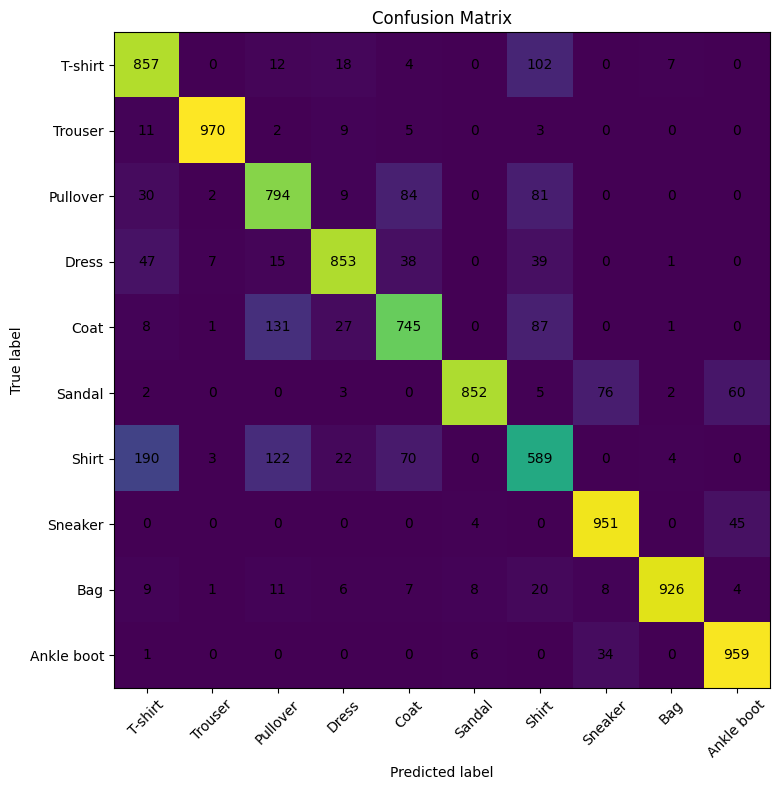

In [ ]:
if __name__ == "__main__":
  knn.plot_confusion_matrix(X_test, y_test, normalize='true')

<Figure size 640x480 with 0 Axes>

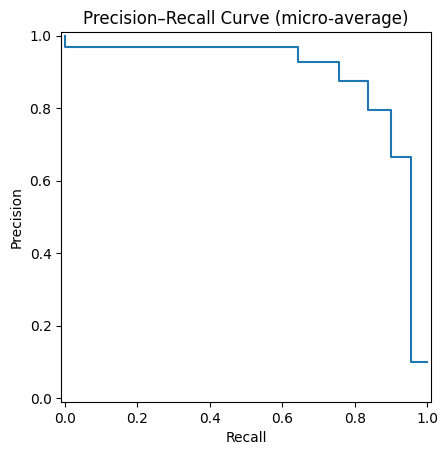

In [ ]:
if __name__ == "__main__":
  knn.plot_precision_recall_curve(X_test, y_test)

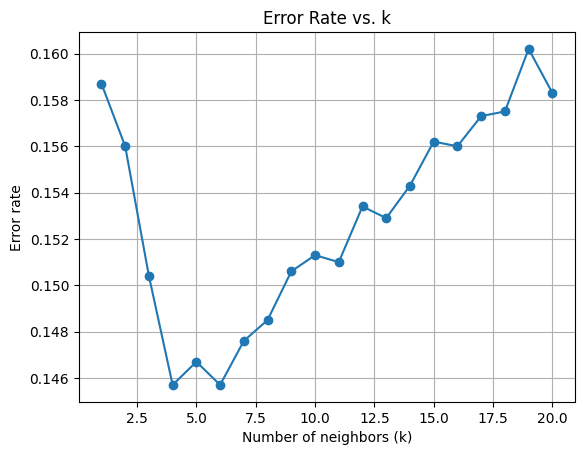

In [ ]:
if __name__ == "__main__":
  knn.plot_error_rate_vs_k(X_train, y_train, X_test, y_test, k_range=range(1, 21))

In [ ]:
if __name__ == "__main__":
  knn.print_classification_report(X_test, y_test)

              precision    recall  f1-score   support

     T-shirt       0.74      0.86      0.80      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.79      0.76      1000
       Dress       0.90      0.85      0.88      1000
        Coat       0.78      0.74      0.76      1000
      Sandal       0.98      0.85      0.91      1000
       Shirt       0.64      0.59      0.61      1000
     Sneaker       0.89      0.95      0.92      1000
         Bag       0.98      0.93      0.95      1000
  Ankle boot       0.90      0.96      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



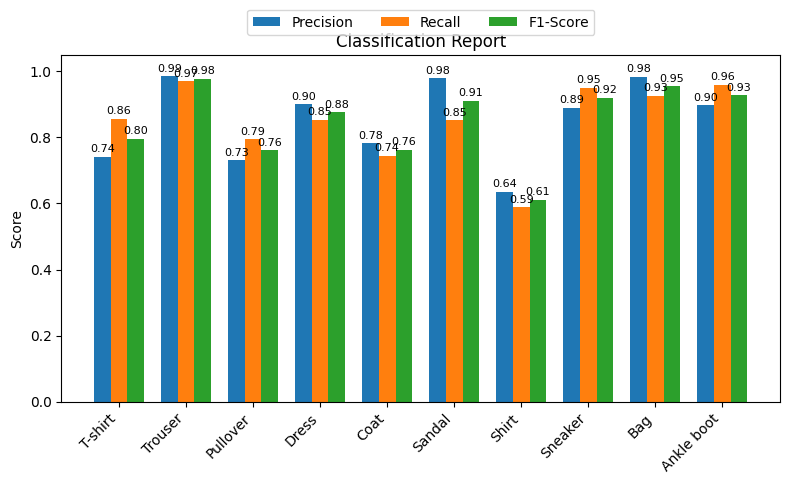

In [ ]:
if __name__ == "__main__":
  plot_classification_report = knn.plot_classification_report(X_test, y_test)

{'T-shirt': {'precision': 0.741991341991342,
  'recall': 0.857,
  'f1-score': 0.7953596287703016,
  'support': 1000.0},
 'Trouser': {'precision': 0.9857723577235772,
  'recall': 0.97,
  'f1-score': 0.9778225806451613,
  'support': 1000.0},
 'Pullover': {'precision': 0.7304507819687213,
  'recall': 0.794,
  'f1-score': 0.7609008145663632,
  'support': 1000.0},
 'Dress': {'precision': 0.9007391763463569,
  'recall': 0.853,
  'f1-score': 0.8762198253723678,
  'support': 1000.0},
 'Coat': {'precision': 0.7817418677859391,
  'recall': 0.745,
  'f1-score': 0.7629288274449565,
  'support': 1000.0},
 'Sandal': {'precision': 0.9793103448275862,
  'recall': 0.852,
  'f1-score': 0.9112299465240642,
  'support': 1000.0},
 'Shirt': {'precision': 0.6360691144708424,
  'recall': 0.589,
  'f1-score': 0.6116303219106958,
  'support': 1000.0},
 'Sneaker': {'precision': 0.8896164639850327,
  'recall': 0.951,
  'f1-score': 0.9192846785886902,
  'support': 1000.0},
 'Bag': {'precision': 0.9840595111583422,